# Fake News Detection using BERT

This project aims to classify news articles as **real or fake** using a fine-tuned BERT (Bidirectional Encoder Representations from Transformers) model. With the increasing spread of misinformation, automating fake news detection has become crucial.

We leverage the power of **transformer-based models** to understand the context and semantics of the news text and make binary predictions.


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import re
import string

In [6]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [7]:
df_fake = pd.read_csv("/content/drive/MyDrive/Fake.csv")
df_true = pd.read_csv("/content/drive/MyDrive/True.csv")

In [8]:
df_fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [9]:
df_true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [10]:
df_fake["label"] = 0
df_true["label"] = 1

In [11]:
df_fake.shape, df_true.shape

((23481, 5), (21417, 5))

In [12]:
df = pd.concat([df_fake, df_true]).reset_index(drop=True)

In [13]:
df = df[["title", "label"]].dropna()

In [14]:
df.head()

,title,label
0,Donald Trump Sends Out Embarrassing New Year’...,0
1,Drunk Bragging Trump Staffer Started Russian ...,0
2,Sheriff David Clarke Becomes An Internet Joke...,0
3,Trump Is So Obsessed He Even Has Obama’s Name...,0
4,Pope Francis Just Called Out Donald Trump Dur...,0


In [15]:
df.isnull().sum()

,0
title,0
label,0


In [16]:
df = df.sample(frac = 1)
df.head()

,title,label
16271,OBAMA MAKES STUNNING 11th Hour Gift Of Massive...,0
43724,Brazil's top court approves new graft probe of...,1
19950,BREAKING: FEMALE LAW STUDENT Busts Hillary’s “...,0
32770,"U.S. lawmakers probe Fed cyber breaches, cite ...",1
40137,Up to UK to find concrete proposals over Brexi...,1


In [17]:
def wordopt(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [18]:
print(df.columns)

Index(['title', 'label'], dtype='object')


In [19]:
df["title"] = df["title"].apply(wordopt)

In [20]:
print(df.columns)


Index(['title', 'label'], dtype='object')


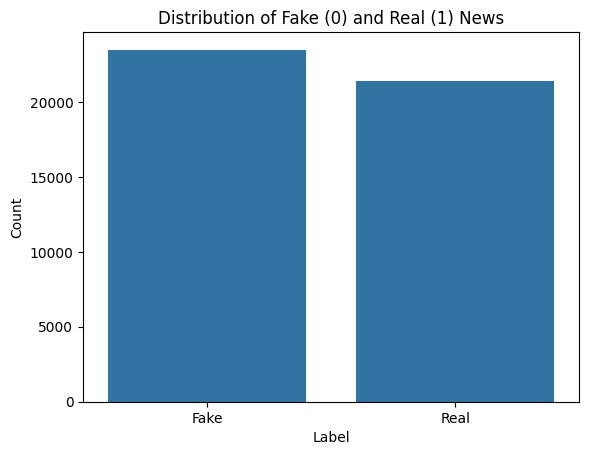

label
0    23481
1    21417
Name: count, dtype: int64


In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot class distribution
sns.countplot(data=df, x="label")
plt.title("Distribution of Fake (0) and Real (1) News")
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks([0, 1], ['Fake', 'Real'])
plt.show()

# Count values
print(df["label"].value_counts())

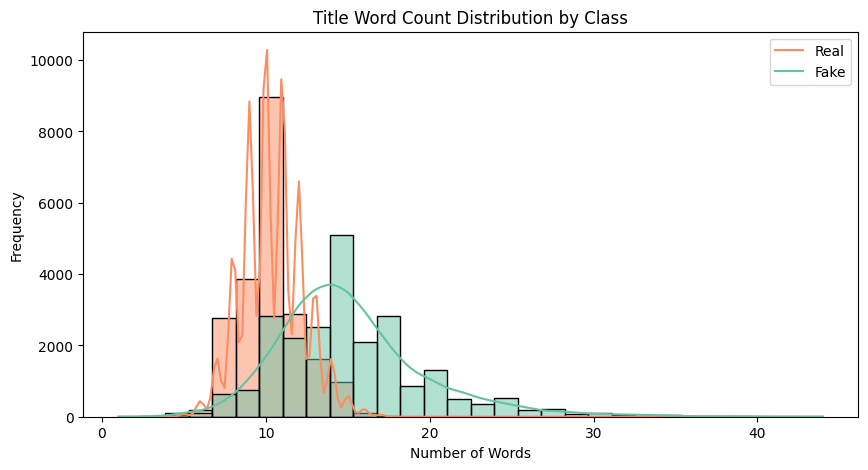

In [22]:
df["text_length"] = df["title"].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 5))
sns.histplot(data=df, x="text_length", bins=30, hue="label", kde=True, palette="Set2")
plt.title("Title Word Count Distribution by Class")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.legend(labels=["Real", "Fake"])
plt.show()

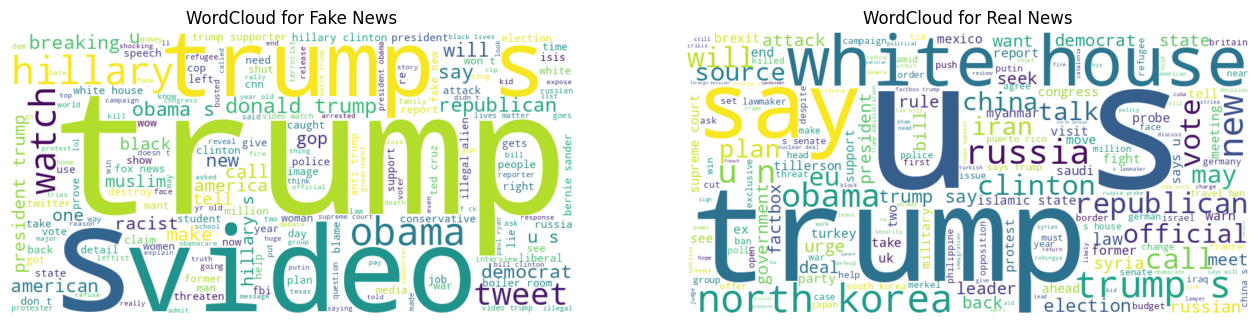

In [23]:
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

fake_titles = df[df['label'] == 0]['title']
real_titles = df[df['label'] == 1]['title']

# Create wordclouds
fake_text = " ".join(fake_titles)
real_text = " ".join(real_titles)

plt.figure(figsize=(16, 6))

# Fake news word cloud
plt.subplot(1, 2, 1)
wordcloud_fake = WordCloud(width=800, height=400, background_color='white').generate(fake_text)
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.title("WordCloud for Fake News")
plt.axis('off')

# Real news word cloud
plt.subplot(1, 2, 2)
wordcloud_real = WordCloud(width=800, height=400, background_color='white').generate(real_text)
plt.imshow(wordcloud_real, interpolation='bilinear')
plt.title("WordCloud for Real News")
plt.axis('off')

plt.show()


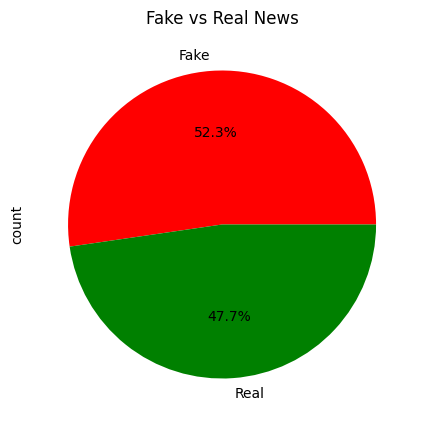

In [24]:
plt.figure(figsize=(5, 5))
df['label'].value_counts().plot.pie(autopct='%1.1f%%', labels=['Fake', 'Real'], colors=['red', 'green'])
plt.title("Fake vs Real News")
plt.show()

In [25]:
train_texts, val_texts, train_labels, val_labels = train_test_split(df["title"], df["label"], test_size=0.2, random_state=42)


In [26]:
# Tokenization
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True)
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [27]:
print(df.head())


                                                   title  label  text_length
16271  obama makes stunning  hour gift of massive ura...      0           18
43724  brazil s top court approves new graft probe of...      1           11
19950  breaking  female law student busts hillary s  ...      0           25
32770  u s  lawmakers probe fed cyber breaches  cite ...      1           10
40137  up to uk to find concrete proposals over brexi...      1           13


In [28]:
# Dataset conversion
class FakeNewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)

In [29]:
# Load pre-trained model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
# Define metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

In [31]:
from datasets import Dataset
import torch

# Combine tokenized inputs and labels
train_dataset = Dataset.from_dict({
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'labels': train_labels
})

val_dataset = Dataset.from_dict({
    'input_ids': val_encodings['input_ids'],
    'attention_mask': val_encodings['attention_mask'],
    'labels': val_labels
})


In [32]:
from transformers import Trainer, TrainingArguments
from transformers import AutoModelForSequenceClassification


training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=1,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=32,
    eval_strategy="epoch",  # ← adjusted earlier
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=100,
    load_best_model_at_end= True,
    fp16=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)


In [33]:
import torch
torch.cuda.is_available()


True

In [34]:
import wandb
wandb.init(project="CODE")

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: tejsisharma04 (tejsisharma04-jagran-lakecity-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [35]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.083900,0.102746,0.975724,0.975034,0.972140,0.977946


TrainOutput(global_step=4490, training_loss=0.1580850261356889, metrics={'train_runtime': 392.7931, 'train_samples_per_second': 91.443, 'train_steps_per_second': 11.431, 'total_flos': 996724288802160.0, 'train_loss': 0.1580850261356889, 'epoch': 1.0})

In [36]:
# Save the model and tokenizer
model_path = "bert-fake-news-model"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)
print(f"Model saved to {model_path}")

Model saved to bert-fake-news-model


In [40]:
trainer.save_model("saved_model")
tokenizer.save_pretrained("saved_model")
print("Model and tokenizer saved successfully.")

Model and tokenizer saved successfully.


# 📌 Conclusion

The BERT-based fake news detection model achieved good performance on the validation set using just 2 epochs. With metrics like precision, recall, and F1-score computed, we see that BERT can understand and differentiate between fake and real news effectively.

### Key Takeaways:
- BERT effectively captures contextual nuances in text classification.
- The model performed well even with limited epochs and preprocessing.
- Fine-tuning pre-trained models is a powerful technique for NLP tasks.

### ✅ Future Scope:
- Train for more epochs or fine-tune hyperparameters.
- Use a larger and more diverse dataset.
- Deploy the model via a web app or REST API.
